# Creating an xG model

In this notebook I am to create an Expected Goals (xG) model using Logistic Regression with the StatsBomb [free data](https://statsbomb.com/academy/). In particular, I use the Messi career data. Of course, this is a heavily biased data set as it only La Liga games Messi has played in and will therefore be dominated by shots taken by Messi. This should be kept in mind throughout the analysis.

I will follow closely some of the techniques used in the [CleKraus GitHub](https://github.com/CleKraus/soccer_analytics) notebook looking at creating an xG model using Logistic Regression.

## Importing modules and data

In [1]:
import sys, os
sys.path.append(os.path.abspath("modules"))
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.linear_model as skl_lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, log_loss
import sklearn.metrics as skm
import sklearn.calibration as skc

import importing_sb as imsb
import draw_pitch as dp

%matplotlib inline

In [2]:
# Importing SB data
data_dir = 'data/open-data/data/'

comp_data = imsb.open_data(data_dir + 'competitions.json')
la_liga_seasons = [i['season_id'] for i in comp_data if i['competition_id'] == 11]
match_data = [sorted(imsb.open_data(data_dir + 'matches/11/{}.json'.format(i)), key = lambda k:k['match_date']) for i in la_liga_seasons]

In [3]:
# Get match ids
years = list(range(2018,2003,-1))
match_ids = []
for i in range(len(years)):
    df = pd.DataFrame(match_data[i])
    match_ids.append(df['match_id'].values)
    
match_ids = np.concatenate(match_ids)

In [4]:
# Create a DataFrame of all the shots (this takes a while)
events = [imsb.open_data(data_dir + 'events/{}.json'.format(i)) for i in match_ids]
shots = [imsb.get_shots(match) for match in events]
shots = pd.concat(shots)

In [5]:
# Remove useless columns such as 'index', 'event_id', 'period', etc
shots = shots[shots.columns[10:]].copy()

In [6]:
# What plays do the shots come from? 91% from open play
shots['shot_type'].value_counts()

Open Play    10252
Free Kick      858
Penalty        140
Corner           1
Name: shot_type, dtype: int64

Some data sorting. First, select only shots from open play.

In [7]:
shots = shots[shots['shot_type'] == 'Open Play']
shots['shot_type'].value_counts()

Open Play    10252
Name: shot_type, dtype: int64

In [8]:
# Create new 'goal' column which is 1 if goal scored and 0 otherwise
shots['goal'] = (shots['outcome'] == 'Goal').astype('int')

In [9]:
shots.head(3)

,x,y,duration,under_pressure,end_x,end_y,end_z,follows_dribble,first_time,freeze_frame,open_goal,sb_xg,deflection,technique,body_part,shot_type,outcome,goal
0,111.7,51.7,0.773778,False,120.0,32.7,0.2,False,True,"[{'location': [103.7, 44.1], 'player': {'id': ...",False,0.095480,False,Half Volley,Right Foot,Open Play,Off T,0
1,114.0,27.0,0.653182,False,120.0,35.0,0.9,False,True,"[{'location': [112.8, 30.5], 'player': {'id': ...",False,0.047924,False,Volley,Left Foot,Open Play,Off T,0
2,92.0,34.5,1.033587,False,117.8,38.5,0.4,False,False,"[{'location': [117.9, 39.8], 'player': {'id': ...",False,0.018477,False,Normal,Left Foot,Open Play,Saved,0


In [10]:
shots['goal'].mean()*100

13.324229418650019

13% of shots are a goal.

## Initial Model

To start, I take just a very simple model which only depends on the x and y coordinates to perform logistic regression.

In [11]:
features = ['x','y']
target = ['goal']

X = shots[features]
y = shots[target]

Split into train and test data sets and apply logistic regression.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [13]:
reg_initial = skl_lm.LogisticRegression()
reg_initial.fit(X_train, np.array(y_train).ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
pred_vals = reg_initial.predict(X_test)

In [15]:
skm.accuracy_score(y_test, pred_vals)*100

87.35370611183355

In [16]:
for i, col in enumerate(X_train.columns):
    print(f"Coefficient of {col}: {reg_initial.coef_[0][i]:.3f}")

Coefficient of x: 0.110
Coefficient of y: 0.007


Accuracy of 87% seems high but this is not a good judge of how good a logistic regression is.

In [17]:
np.unique(pred_vals)

array([0])

The model just predicted no goal the whole time and had that accuracy!

### Log loss

Log loss is one good way to judge how well the model is performing. The loss function is the same as the cost function in logistic regression and takes the form

$$
-y \log(h(x)) - (1-y)\log(1-h(x))\ ,
$$

where $h(x)$ is the predicted probability.

In [18]:
pred_probs = reg_initial.predict_proba(X_test)[:,1]
skm.log_loss(y_test,pred_probs)

0.3516480808870494

Compare to simply taking 13% of all shots being a goal.

In [19]:
skm.log_loss(y_test,[0.1332]*len(y_test))

0.37980659416884427

So the initial, very crude model is performing slightly better than just predicting the average rate for goal scoring.

### ROC AUC

*The AUC of a model is the probability that the model ranks a random positive example (i.e. a successful shot) more highly than a random negative example (i.e. unsuccessful shot)*

Basically it measures the ranking of positive vs negative examples and not the probabilities that are actually assigned to the examples, which is what we are interested in. It can still be a useful metric however, just not the ultimate one to measure the model performance by.

This can be shown by the following example.

In [20]:
skm.roc_auc_score(y_test, pred_probs)*100

69.63012428688832

That means that when randomly selecting a successful shot and an unsuccessful shot, there is a 69.63% chance that our model gives the successful shot a higher probability than the unsuccessful shot.

To show a flaw in ROC for this analysis now create predictions which are 6 times larger than the model predicted.

In [21]:
np.mean(pred_probs*6)*100

79.91780486949597

Now 79.9% of all shots are goals.

In [22]:
print("Log loss for overpredicting model:", skm.log_loss(y_test, pred_probs*6))
print("ROC score for overpredicting model:", skm.roc_auc_score(y_test, pred_probs*6)*100)

Log loss for overpredicting model: 9.646064378161212
ROC score for overpredicting model: 69.63012428688832


The log loss is much, much higher but the ROC score is the same!

## Identifying outliers

I should look at the data to see if there are any peculiarities/outliers.

In [24]:
df_goals = shots[shots['goal'] == 1].copy()

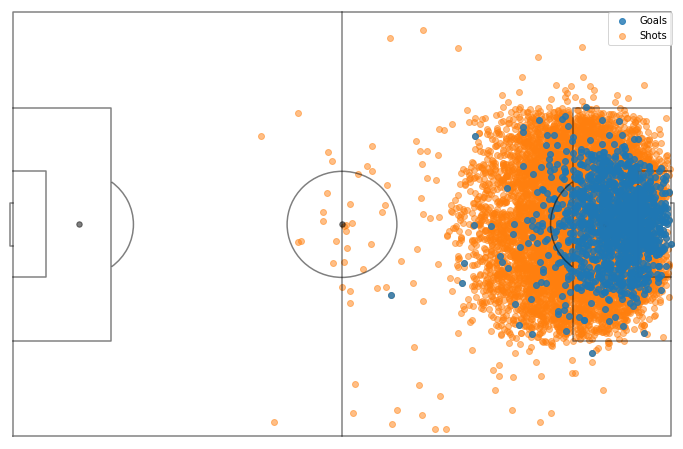

In [27]:
fig,ax=dp.draw_pitch('w','k','h','f',alpha=0.5)
ax.scatter(df_goals['x'],80-df_goals['y'],zorder=2,alpha=0.8,label='Goals')
ax.scatter(shots['x'],80-shots['y'],alpha=0.5,zorder=1,label='Shots')
ax.legend()
plt.show()

With the exception of a goal near the halfway line, nothing looks too extraordinary from just looking at location.

Perhaps it will be more informative to look at histograms. By splitting the pitch up into zones then looking at the goal probability (goals divided by shots) per zone some peculiarities could become clearer. In particular, zones from which few shots have been taken yet a lucky goal went in.

First, the shot histogram.

In [29]:
H_shots, *_ = np.histogram2d(shots['y'],shots['x'],bins=(15,24),range=[[0,80],[0,120]])

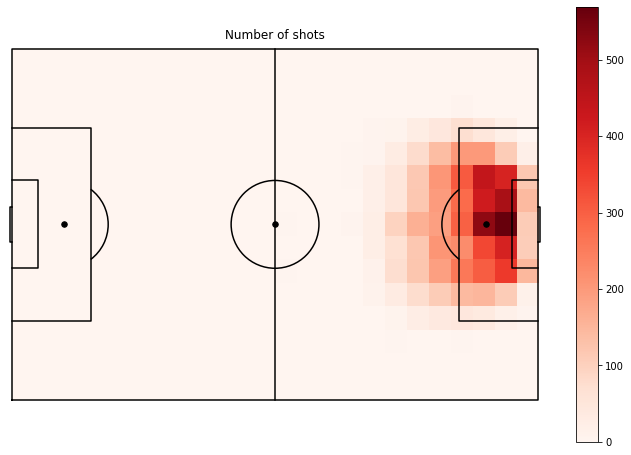

In [30]:
fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(H_shots, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Number of shots")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

This all seems ordinary. Next the goal histogram.

In [31]:
H_goals, x_edges, y_edges = np.histogram2d(df_goals['y'],df_goals['x'],bins=(15,24),range=[[0,80],[0,120]])

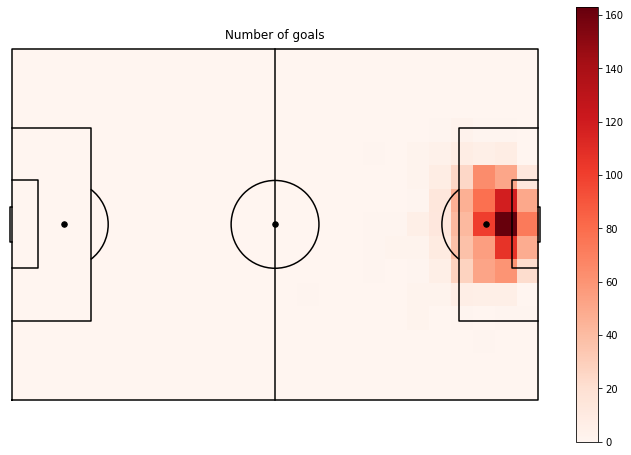

In [32]:
fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(H_goals, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Number of goals")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Again, this looks as one would expect.

Finally, the goal probability histogram.

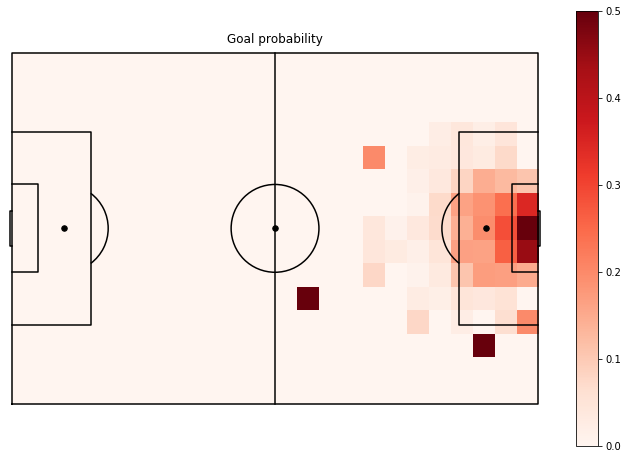

In [33]:
fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(np.divide(H_goals, H_shots, where=H_shots!=0), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds, vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title("Goal probability")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We see from the goal probability heatmap that there are some regions where there is an incorrectly high probability due to low shot count but a lucky goal.

There are a couple of ways to deal with this.
- Just delete those data points
- Use our knowledge to change the target in regions where we believe the probability should be basically zero.

Taking the approach of the second point, the idea is to compare shot and pass count. In zones where the probability of passing is much larger than shooting the number of goals is set to zero. 

In [28]:
passes = [imsb.get_pass(match) for match in events]
passes = pd.concat(passes)

In [34]:
passes = passes[passes['pass_type'] == 'Standard']

In [35]:
H_passes, ygrid, xgrid = np.histogram2d(passes['y'],passes['x'],bins=(15,24),range=[[0,80],[0,120]])

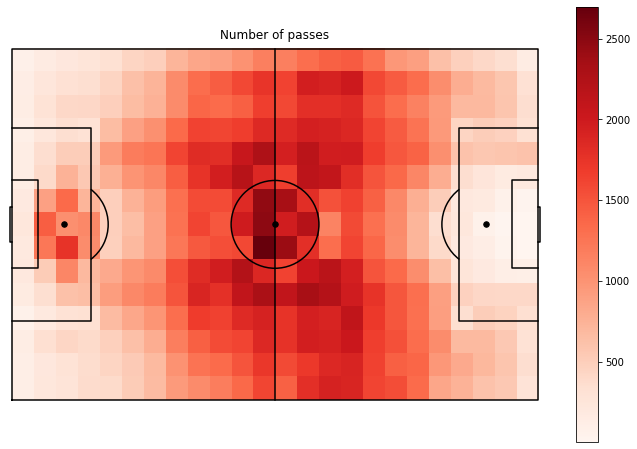

In [36]:
fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(H_passes, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Number of passes")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

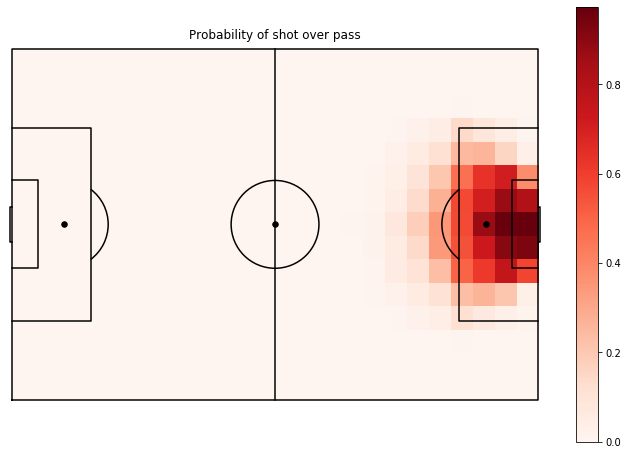

In [37]:
fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(H_shots/(H_passes+H_shots), extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Probability of shot over pass")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

We see that it only becomes likely to take a shot near the penalty area, as expected. Let's say that for any region where the probability of shooting is <1% then the goals scored from there is zero.

In [38]:
# Find zone mids
shots['x_zone'] = pd.cut(shots['x'],xgrid).apply(lambda x: x.mid)
shots['y_zone'] = pd.cut(shots['y'],ygrid).apply(lambda x: x.mid)

In [39]:
shots_per_zone = shots.groupby(['x_zone','y_zone']).agg(num_shots=("goal","count")).reset_index()

In [40]:
passes['x_zone'] = pd.cut(passes['x'],xgrid).apply(lambda x: x.mid)
passes['y_zone'] = pd.cut(passes['y'],ygrid).apply(lambda x: x.mid)

In [41]:
passes_per_zone = passes.groupby(["x_zone","y_zone"]).agg(num_passes=("event_id","count")).reset_index()

Merge this into existing dataframe and then change shots in any zones that have <1% shot prob to have goal=0.

In [43]:
shots_passes = pd.merge(shots_per_zone, passes_per_zone)

In [44]:
shots_passes["shot_prob"] = shots_passes["num_shots"]/(shots_passes['num_shots'] + shots_passes["num_passes"])

In [45]:
shots = pd.merge(shots, shots_passes[["x_zone","y_zone","shot_prob"]], on=["x_zone","y_zone"], how='left')
# Using how='left' means any keys from shots that do not appear in shots_passes would appear as NaN in the 'shot_prob'
#column. However, there shouldn't be any cases of this happening.

Now change shots that occur in a region where there is <1% shot probability to always have 'goal'=0.

In [46]:
# Number of goals before the change
num_goals_before = shots['goal'].sum()
num_goals_before

1366

In [47]:
shots['goal'].where(shots['shot_prob'] > 0.01, 0, inplace=True)

In [48]:
# Numer of goals after the change
print("This change removed", num_goals_before - shots['goal'].sum(), "goals.")

This change removed 4 goals.


Let's check to see how that has changed the goal probability map.

In [50]:
df_goals = shots[shots['goal'] == 1].copy()

In [51]:
df_goals_num = df_goals.groupby(['x_zone','y_zone']).agg(goal_num=("goal","count")).reset_index()
df_shots_num = shots.groupby(['x_zone','y_zone']).agg(shot_num=("goal","count")).reset_index()
goal_nums = df_goals_num['goal_num'].values
shot_nums = df_shots_num['shot_num'].values
df_goals_num['goal_prob'] = np.divide(goal_nums, shot_nums, out=np.zeros_like(goal_nums,dtype=float), where=shot_nums!=0)

# This creates a matrix of 'y_zone' rows and 'x_zone' columns, which is what we want when plotting a pitch
# horizontally. However, then keep in mind that the top of the pitch is the first row in y_zone!
df_goals_img = np.array(df_goals_num.pivot('y_zone','x_zone','goal_prob'))

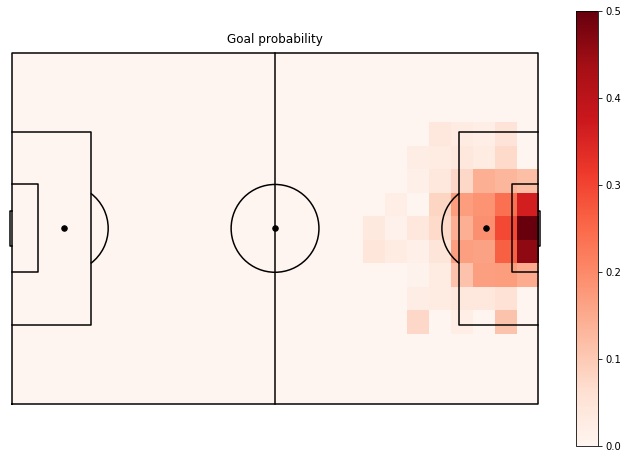

In [52]:
fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(df_goals_img, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds, vmin=0, vmax=0.5)
fig.colorbar(pos, ax=ax)
ax.set_title("Goal probability")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

This definitely looks better than before.

Finally, let's check the change in the log loss. Given we've only removed 4 goals I expect very little difference.

Here, I will define train and test DataFrames that can be used throughout the rest of the analysis.

In [53]:
df_train, df_test, _, _ = train_test_split(shots, shots["goal"], test_size=0.30, random_state=42)

In [54]:
features = ['x','y']
target = ['goal']

reg_outlier = skl_lm.LogisticRegression()
reg_outlier.fit(df_train[features], np.array(df_train[target]).ravel())
pred_probs = reg_outlier.predict_proba(df_test[features])[:,1]
skm.log_loss(df_test[target],pred_probs)

0.3501784916784722

In [55]:
# Previous Logistic Regression without the outliers removed for comparison
features = ['x','y']
target = ['goal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
reg_outlier = skl_lm.LogisticRegression()
reg_outlier.fit(X_train, np.array(y_train).ravel())
pred_probs = reg_outlier.predict_proba(X_test)[:,1]
skm.log_loss(y_test,pred_probs)

0.3516480808870494

This has reduced from 0.3516 to 0.3502, so a 0.3% improvement.

## Check monotonicity of current features

At the heart of logistic regression it is still just linear fitting. As such, the features should monotone with the data (always increasing or descreasing, ideally linearly). Let's check that this is the case.

### x position

In [56]:
df = shots[['x','goal']].copy()

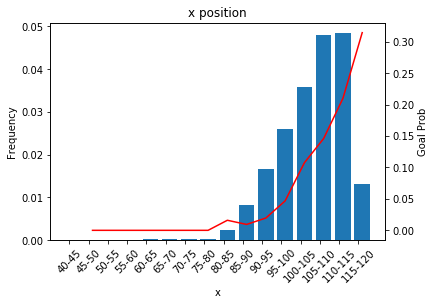

In [57]:
df = shots[['x','goal']].copy()

fig,ax = plt.subplots()
bins = np.arange(40,125,5)
ax.hist(np.clip(df['x'],bins[0],bins[-1]), bins=bins, density=True, rwidth=0.8)
ax.set_xticks([bins[i]+1.5 for i in range(len(bins)-1)])
ax.set_xticklabels(['{}-{}'.format(bins[i],bins[i+1]) for i in range(len(bins)-1)], rotation=45)
ax.set_xlabel('x')
ax.set_ylabel('Frequency')
ax.set_title("x position")

df['binned'] = pd.cut(df['x'], bins)
df['bin_mids'] = df['binned'].apply(lambda x: x.mid)
goal_probs = (df.groupby('bin_mids')['goal'].sum()/df.groupby('bin_mids').size())

ax2 = ax.twinx()
ax2.plot(goal_probs.index, goal_probs.values,color='red')
ax2.set_ylabel("Goal Prob")

plt.show()

On the whole this looks good. A small spike a 80-85 but otherwise as expected; the closer to the opponents end of the pitch (larger x) the better the chance of scoring.

### y position

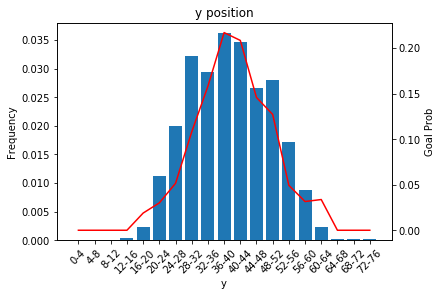

In [58]:
df = shots[['y','goal']].copy()

fig,ax = plt.subplots()
bins = np.arange(0,80,4)
ax.hist(np.clip(df['y'],bins[0],bins[-1]), bins=bins, density=True, rwidth=0.8)
#ax.hist(shots['dist'], bins=20, range=(0,40), density=True, rwidth=0.8)
#[bins[i]+1 for i in range(len(bins)-1)]
ax.set_xticks([bins[i]+2 for i in range(len(bins)-1)])
ax.set_xticklabels(['{}-{}'.format(bins[i],bins[i+1]) for i in range(len(bins)-1)], rotation=45)
ax.set_xlabel('y')
ax.set_ylabel('Frequency')
ax.set_title("y position")

df['binned'] = pd.cut(df['y'], bins)
df['bin_mids'] = df['binned'].apply(lambda x: x.mid)
goal_probs = (df.groupby('bin_mids')['goal'].sum()/df.groupby('bin_mids').size())

ax2 = ax.twinx()
ax2.plot(goal_probs.index, goal_probs.values,color='red')
ax2.set_ylabel("Goal Prob")

plt.show()

This is exactly what is not wanted, but it is to be expected. The closer a shot is to the centre of the pitch the more likely it is to be a goal.

At this point the features need to be rethought. Perhaps a better description that x and y is rather the distance to goal and the angle of the goal that can be seen. Let's make those features and test the new model.

## Defining new features - Distance and Angle

### Distance

I will take it to be the distance to the centre of the goal.

In [59]:
xgoal = 120
ygoal = 40
x1 = shots['x'].values
y1 = shots['y'].values
d = np.sqrt((xgoal-x1) ** 2 + (ygoal-y1) ** 2)
shots['dist'] = d

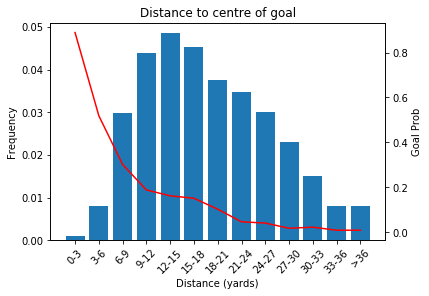

In [60]:
df = shots[['dist','goal']].copy()

fig,ax = plt.subplots()
bins = np.arange(0,42,3)
ax.hist(np.clip(shots['dist'],bins[0],bins[-1]), bins=bins, density=True, rwidth=0.8)
#ax.hist(shots['dist'], bins=20, range=(0,40), density=True, rwidth=0.8)
#[bins[i]+1 for i in range(len(bins)-1)]
ax.set_xticks([bins[i]+1.5 for i in range(len(bins)-1)])
ax.set_xticklabels(['{}-{}'.format(bins[i],bins[i+1]) for i in range(len(bins)-2)] + ['>{}'.format(bins[-2])], rotation=45)
ax.set_xlabel('Distance (yards)')
ax.set_ylabel('Frequency')
ax.set_title("Distance to centre of goal")

df['binned'] = pd.cut(df['dist'], bins)
df['bin_mids'] = df['binned'].apply(lambda x: x.mid)
goal_probs = (df.groupby('bin_mids')['goal'].sum()/df.groupby('bin_mids').size())

ax2 = ax.twinx()
ax2.plot(goal_probs.index, goal_probs.values,color='red')
ax2.set_ylabel("Goal Prob")

plt.show()

Looks monotone so that's good!

### Angle

This is the angle of the visible goal from the position the shot is taken. It is described by the equation

$$
\tan\theta = \frac{bx}{x^2+y^2-b^2/4}\ ,
$$

where $b$ is the width of the goal, $x$ is the horizontal distance from the goal line (the right-most touchline in Statsbomb coordinates which is x=120) and $y$ is the vertical distance from the centre of the goal (y=40). With $b=8$ the angle for every shot can be calculated.

One can use the arctan method as shown by David Sumpter on Friends of Tracking, however this fails when the angle is 90 degrees (since $\tan(90)$ is infinite) and also gives negative angles for angles above 90.

In [61]:
angle = np.arctan( (8*(120-shots['x'])) / ((120-shots['x'])**2 + np.abs(40-shots['y'])**2 - (8**2)/4) )*(180/np.pi)
print(max(angle))
print(min(angle))

89.99999999999986
-89.70158718000505


Instead one can follow the same derivation but keep it in terms of $\cos(\theta)$, which is helpful because $\arccos$ is always positive and will give the correct angle straight away, as well as being defined at $\cos(90)$. The downside is the formula is a bit more messy.

In [64]:
a = np.sqrt((120-shots['x'])**2+((40-shots['y'])-8/2)**2)
c = np.sqrt((120-shots['x'])**2+((40-shots['y'])+8/2)**2)
angle = np.arccos(((120-shots['x'])**2 + (40-shots['y'])**2 - (8/2)**2)/(a * c))*(180/np.pi)
print("Max angle:",max(angle))
print("Min angle:",min(angle))
shots["angle"] = angle

Max angle: 180.0
Min angle: 0.9941870555060618


Let's put the data into 10 degree angle bins and see how many shots are taken in each bin.

In [65]:
bins = np.arange(0,190,10)

df = shots[['angle','goal']].copy()
df['binned'] = pd.cut(df['angle'], bins)
df['bin_mids'] = df['binned'].apply(lambda x: x.mid)
df['bin_mids'].value_counts().sort_values()

175.0       1
165.0       2
155.0       3
145.0       4
115.0       5
135.0       6
125.0       9
105.0      12
95.0       24
85.0       40
75.0       74
65.0      192
5.0       288
55.0      391
45.0      672
35.0     1239
25.0     2605
15.0     4685
Name: bin_mids, dtype: int64

Beyond around 110 degrees there are very few shots per bin. Therefore, it may be better to clip the angles around here and combine them into a single >110 bin.

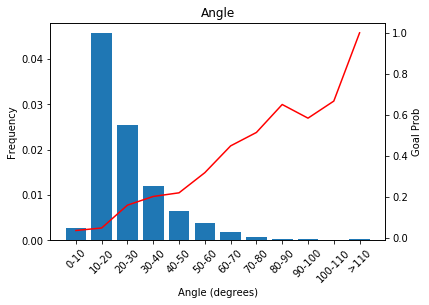

In [66]:
df = shots[['angle','goal']].copy()

fig,ax = plt.subplots()
bins = np.arange(0,130,10)
ax.hist(shots['angle'].clip(upper=120), bins=bins, density=True, rwidth=0.8)
ax.set_xticks([bins[i]+5 for i in range(len(bins)-1)])
ax.set_xticklabels(['{}-{}'.format(bins[i],bins[i+1]) for i in range(len(bins)-2)] + ['>{}'.format(bins[-2])], rotation=45)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Frequency')
ax.set_title("Angle")

df['binned'] = pd.cut(df['angle'], bins)
df['bin_mids'] = df['binned'].apply(lambda x: x.mid)
goal_probs = (df.groupby('bin_mids')['goal'].sum()/df.groupby('bin_mids').size())

ax2 = ax.twinx()
ax2.plot(goal_probs.index, goal_probs.values,color='red')
ax2.set_ylabel("Goal Prob")

plt.show()

On the whole this follows expectations (with the exception of the spike in 80-90) that a larger angle presents a better opportunity of scoring.

Let's train a new logistic regression with the new Distance and Angle features. Begin by adding distance and angle to the train and test data.

In [67]:
xgoal = 120
ygoal = 40
x1 = shots['x'].values
y1 = shots['y'].values
d = np.sqrt((xgoal-x1) ** 2 + (ygoal-y1) ** 2)
shots['dist'] = d

In [70]:
a = np.sqrt((120-shots['x'])**2+((40-shots['y'])-8/2)**2)
c = np.sqrt((120-shots['x'])**2+((40-shots['y'])+8/2)**2)
angle = np.arccos(((120-shots['x'])**2 + (40-shots['y'])**2 - (8/2)**2)/(a * c))*(180/np.pi)

Define functions for adding the *Distance* and *Angle* features.

In [71]:
def add_feat_dist(df):
    df = df.copy()
    xgoal = 120
    ygoal = 40
    x1 = df['x'].values
    y1 = df['y'].values
    d = np.sqrt((xgoal-x1) ** 2 + (ygoal-y1) ** 2)
    df['dist'] = d
    
    return df
    
def add_feat_angle(df):
    df = df.copy()
    xgoal = 120
    ygoal = 40
    a = np.sqrt((xgoal-df['x'])**2+((ygoal-df['y'])-8/2)**2)
    c = np.sqrt((xgoal-df['x'])**2+((ygoal-df['y'])+8/2)**2)
    angle = np.arccos(((xgoal-df['x'])**2 + (ygoal-df['y'])**2 - (8/2)**2)/(a * c))*(180/np.pi)
    df['angle'] = angle
    
    return df

In [72]:
df_train = add_feat_dist(df_train)
df_train = add_feat_angle(df_train)
df_test = add_feat_dist(df_test)
df_test = add_feat_angle(df_test)

Train the new model.

In [73]:
features = ['dist','angle']
target = ['goal']
reg_feat = skl_lm.LogisticRegression()
reg_feat.fit(df_train[features], np.array(df_train[target]).ravel())
pred_probs = reg_feat.predict_proba(df_test[features])[:,1]
skm.log_loss(df_test[target],pred_probs)

0.3368968249301392

Transforming to these new features has reduced the log loss from 0.3502 to 0.3369, a 3.7% reduction.

### Overprediction

To have an understanding of where (in what zones) the model performs well or struggles we can compare the actual goal probability to the predicted xG.

To begin, I will look at the overprediction associated to the *Angle* feature. The average angle of a shot in each zone can be seen below.

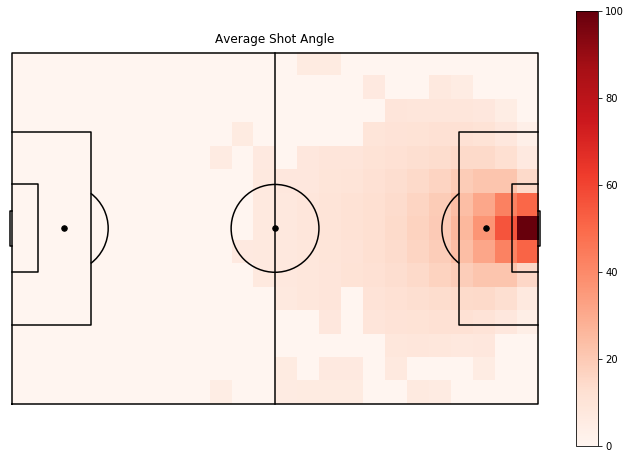

In [74]:
df = shots.groupby(['x_zone','y_zone']).agg(angle_avg=("angle","mean")).reset_index()
df['angle_avg'].fillna(0,inplace=True)
df_img = np.array(df.pivot('y_zone','x_zone','angle_avg'))

fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(df_img, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title("Average Shot Angle")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Using the xG model, I now calculate the overprediction of every shot by taking the difference *Prediction*-*Goal*. I can then look at the mean overprediction in each zone and create a new pitch showing this.

In [75]:
features = ['dist','angle']
target = ['goal']
pred_probs_train = reg_feat.predict_proba(df_train[features])[:,1]
df_train['prediction'] = pred_probs_train
df_train['overprediction'] = df_train['prediction'] - df_train['goal']

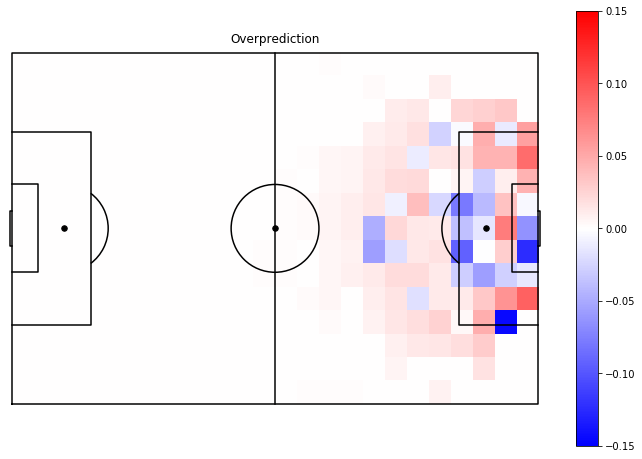

In [76]:
df_overpred = df_train.groupby(['x_zone','y_zone']).agg(overpred_mean=("overprediction","mean")).reset_index()
df_overpred['overpred_mean'].fillna(0,inplace=True)
df_overpred_img = np.array(df_overpred.pivot("y_zone","x_zone","overpred_mean"))

fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(df_overpred_img, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.bwr, vmin=-0.15, vmax=0.15)
fig.colorbar(pos, ax=ax)
ax.set_title("Overprediction")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

Perhaps central shots from the edge of the box are underpredicted and more zones from the right side seem to be underpredicted, but otherwise there are no stand-out trends. 

To better understand how overprediction changes with just angle we can plot that.

Here I create a general *overprediction plot* function ``prob_overpred_plot`` which can take a dataframe and a specified feature from which to create the plot. It is also set up to handle both binary dependent features and continuous features, with *bins* which can be specified.

In [78]:
def prob_overpred_plot(df,col,bins='class',cut=False):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,5))
    
    df = df[[col,'goal','overprediction']].copy()
    
    if type(bins) == str:
        bins = [0,1,2]
        bin_mids = [0.5,1.5]
        xticks = [0.5,1.5]
        xticklabels = [0,1]
        xticklabelopt = {}
        
        goal_probs = df.groupby(col).mean()['goal']
        overpred = df.groupby(col).mean()['overprediction']
        
    else:
        if cut:
            cut_val = bins[-1]
            df[col] = df[col].clip(upper=cut_val)
        bin_mid = (bins[1]-bins[0])/2
        bin_mids = bins[:-1] + bin_mid
        xticks = bins[:-1] + bin_mid #[bins[i]+bin_mid for i in range(len(bins)-1)]
        xticklabels = ['{}-{}'.format(bins[i],bins[i+1]) for i in range(len(bins)-2)] + ['>{}'.format(bins[-2])]
        xticklabelopt = {'rotation': 45}
        
        df['binned'] = pd.cut(df[col], bins)
        df['bin_mids'] = df['binned'].apply(lambda x: x.mid)
        goal_probs = (df.groupby('bin_mids')['goal'].sum()/df.groupby('bin_mids').size())
        overpred = (df.groupby('bin_mids')['overprediction'].sum()/df.groupby('bin_mids').size())
        
    ax1.hist(df[col], bins=bins, density=True, rwidth=0.8)
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticklabels, xticklabelopt)
    ax1.set_xlabel(col)
    ax1.set_ylabel("Frequency")
    ax1.set_title("Scoring Probability")

    ax12 = ax1.twinx()
    ax12.plot(xticks, goal_probs.values*100,color='red')
    ax12.set_ylim(0,max(goal_probs.values*100)+1)
    ax12.set_ylabel("Goal Probability")
    ax12.grid(alpha=0.3)

    ax2.hist(df[col], bins=bins, density=True, rwidth=0.8)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticklabels, xticklabelopt)
    ax2.set_xlabel(col)
    ax2.set_ylabel("Frequency")
    ax2.set_title("Overprediction")

    ax22 = ax2.twinx()
    ax22.plot(xticks, overpred.values,color='red')
    ax22.set_ylabel("Overprediction")
    ax22.grid(alpha=0.3)


    plt.tight_layout()
    plt.show()

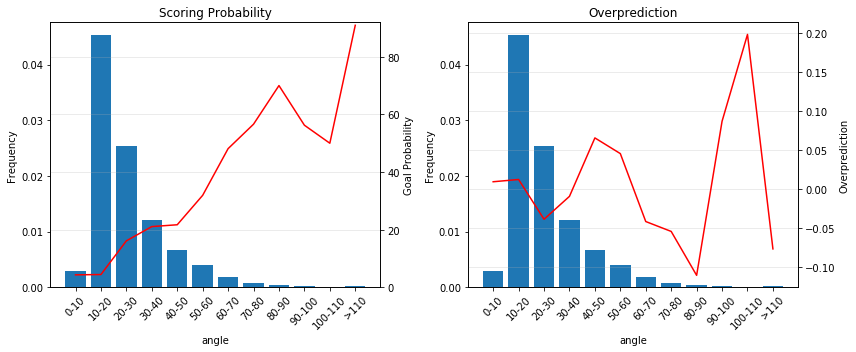

In [79]:
prob_overpred_plot(df_train,'angle',bins = np.arange(0,130,10),cut=True)

On the whole the overprediction is quite low. However, it seems large angles are the least accurate.

Perhaps some of these could be described with additional features.

## Adding additional features

Using the different event types recorded in the data I will attempt to create some new features to better describe the shots. First, let's look at some of the event types that could be useful.

In [80]:
shots.columns

Index(['x', 'y', 'duration', 'under_pressure', 'end_x', 'end_y', 'end_z',
       'follows_dribble', 'first_time', 'freeze_frame', 'open_goal', 'sb_xg',
       'deflection', 'technique', 'body_part', 'shot_type', 'outcome', 'goal',
       'x_zone', 'y_zone', 'shot_prob', 'dist', 'angle'],
      dtype='object')

The variables `under_pressure`, `follows_dribble`, `first_time`, `open_goal`, `deflection`, `technique` and `body_part` all sound promising. Up to this point I have only included shots from open play, but looking at `shot_type`, another detail in the StatsBomb data, could allow me to include shots direct from Corners and Free Kicks. `body_type` could be even more useful but StatsBomb data has no indicator for strong foot, so I will just have to exam foot against head.

`freeze_frame` could also be very useful, giving the location of every relevant player at the time of the shot. This, for example, could be used to calculate the number of players in the cone from striker to goal which could then be used as another feature.

The potential usefulness of a new feature will initially be judged by the amount of overprediction. For example, if the model currently largely overpredicts the goal probability for shots that are `under_pressure` then it would likely be a good feature, especially if a reasonable amount of shots are taken under pressure.

### Under pressure

First, I will look at the `under_pressure` event type. ~18% of shots are labelled as under pressure.

In [81]:
shots['under_pressure'].value_counts()

False    8399
True     1853
Name: under_pressure, dtype: int64

Convert to 1 and 0 for True and False.

In [82]:
df_train['under_pressure'] = df_train['under_pressure'].astype(int)
df_test['under_pressure'] = df_test['under_pressure'].astype(int)

In [83]:
df_train.groupby('under_pressure').mean()['goal']

under_pressure
0    0.141302
1    0.110425
Name: goal, dtype: float64

In [84]:
df_train.groupby('under_pressure').mean()['overprediction']

under_pressure
0   -0.010791
1    0.049004
Name: overprediction, dtype: float64

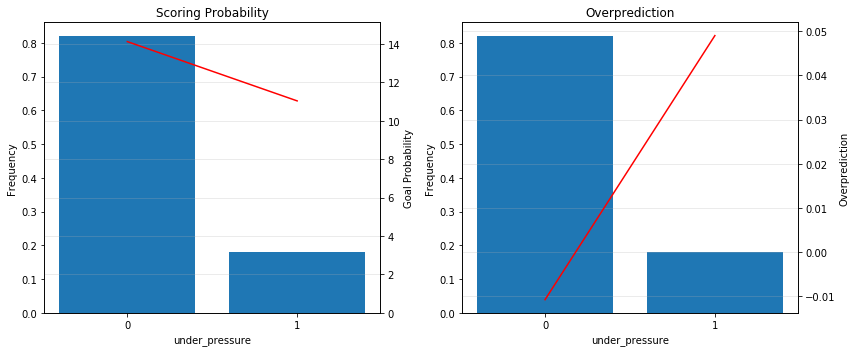

In [85]:
prob_overpred_plot(df_train,'under_pressure')

Scoring probability clearly drops if under pressure but the total error from overpredicting is $\sim0.05-(-0.01)=0.06$ which isn't particularly large, so I don't expect a large improvement in the model.

### Follows dribble

All ~10,000 shots do not follow a dribble so this cannot be used as a feature,

In [86]:
shots['follows_dribble'].value_counts()

False    10252
Name: follows_dribble, dtype: int64

### First time

Around 33% of shots are taken first time so this could be an important feature.

In [87]:
shots['first_time'].value_counts()

False    6848
True     3404
Name: first_time, dtype: int64

In [88]:
df_train['first_time'] = df_train['first_time'].astype(int)
df_test['first_time'] = df_test['first_time'].astype(int)
print(df_train.groupby('first_time').mean()['goal'])
print(df_train.groupby('first_time').mean()['overprediction'])

first_time
0    0.108394
1    0.191833
Name: goal, dtype: float64
first_time
0    0.017706
1   -0.036338
Name: overprediction, dtype: float64


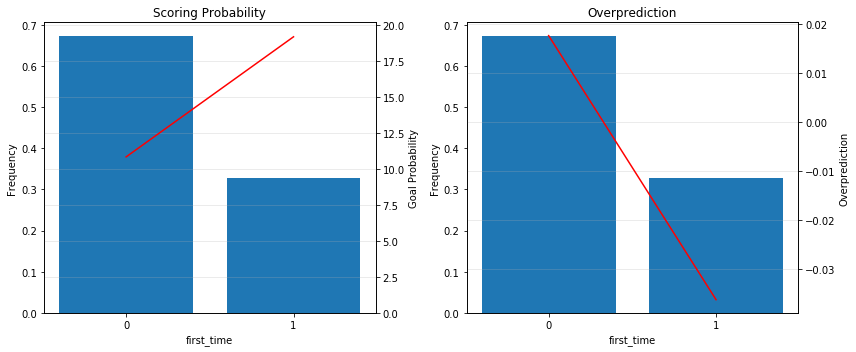

In [89]:
prob_overpred_plot(df_train,'first_time')

Again scoring probability clearly increases yet total overprediction is only $\sim 0.054$.

### Open goal

Only around 1.3% of shots are with an open goal.

In [90]:
shots['open_goal'].value_counts()

False    10113
True       139
Name: open_goal, dtype: int64

In [91]:
df_train['open_goal'] = df_train['open_goal'].astype(int)
df_test['open_goal'] = df_test['open_goal'].astype(int)
print(df_train.groupby('open_goal').mean()['goal'])
print(df_train.groupby('open_goal').mean()['overprediction'])

open_goal
0    0.125318
1    0.887755
Name: goal, dtype: float64
open_goal
0    0.005274
1   -0.380924
Name: overprediction, dtype: float64


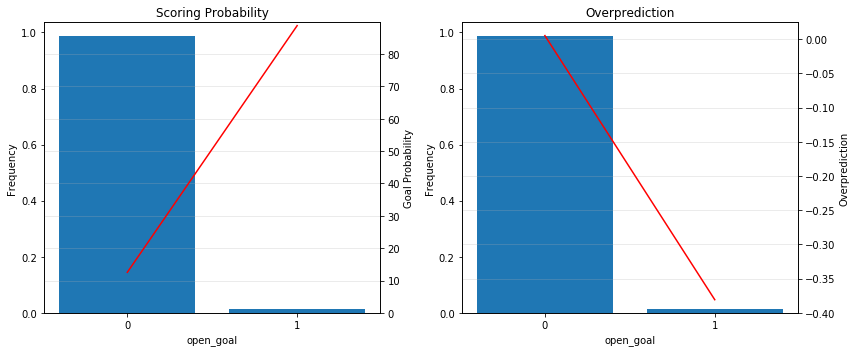

In [92]:
prob_overpred_plot(df_train,'open_goal')

The model currently largely underpredicts open goal shots, as might be expected. However, as mentioned these are only ~1.3% of shots so it is unlikely to make a large difference to the model overall.

### Technique

Around 80% of shots are taken with a *Normal* technique.

In [93]:
shots['technique'].value_counts()

Normal           8185
Half Volley      1025
Volley            674
Lob               213
Overhead Kick      76
Diving Header      49
Backheel           30
Name: technique, dtype: int64

Create a dummy variable for each of these *techniques*.

In [94]:
df_dummy_tech_train = pd.get_dummies(df_train['technique'])
df_dummy_tech_test = pd.get_dummies(df_test['technique'])
df_dummy_tech_train.head()

,Backheel,Diving Header,Half Volley,Lob,Normal,Overhead Kick,Volley
5766,0,0,0,0,1,0,0
3128,0,0,0,0,1,0,0
10031,0,0,0,0,1,0,0
4098,0,0,0,0,1,0,0
7286,0,0,0,0,0,0,1


In [95]:
# Add the new dummy variables to the training and test sets
df_train = pd.concat([df_train, df_dummy_tech_train], axis=1)
df_test = pd.concat([df_test, df_dummy_tech_test], axis=1)

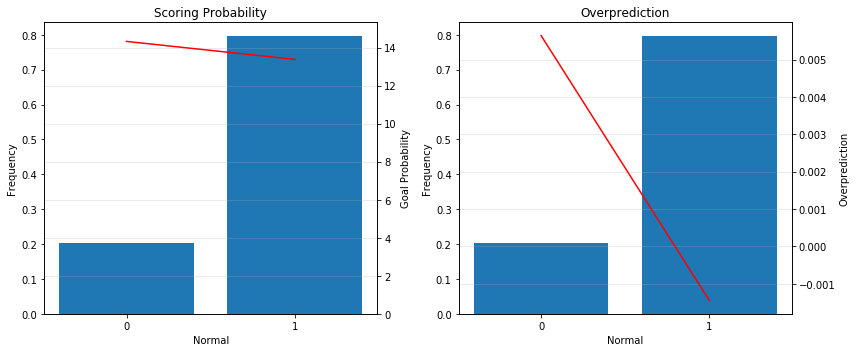

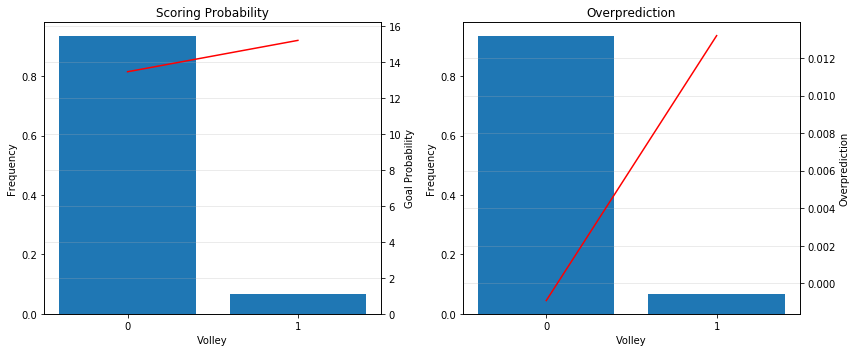

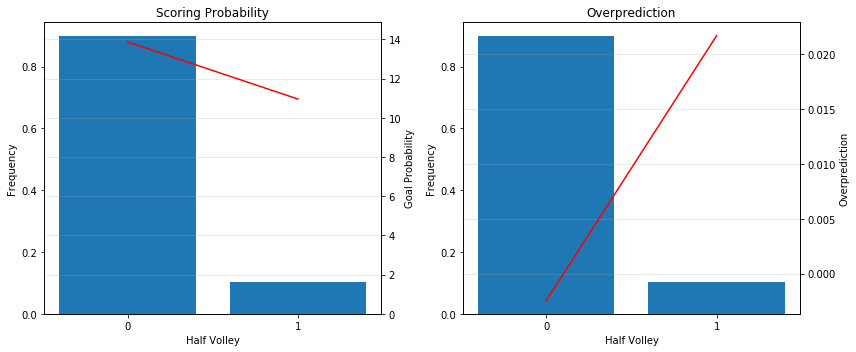

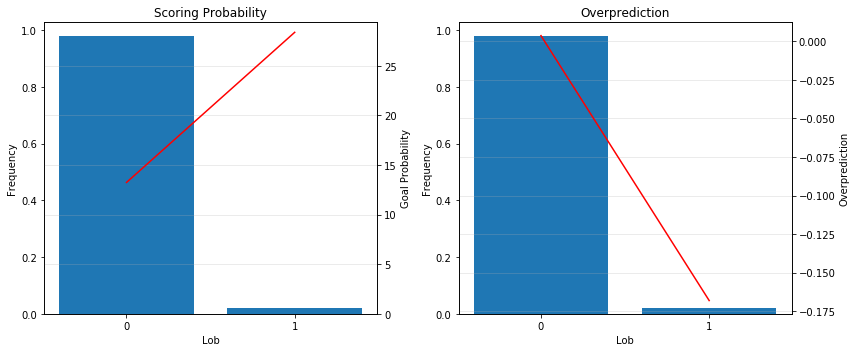

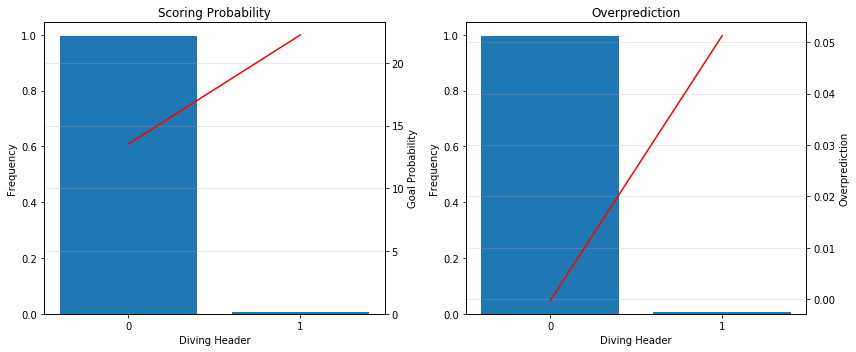

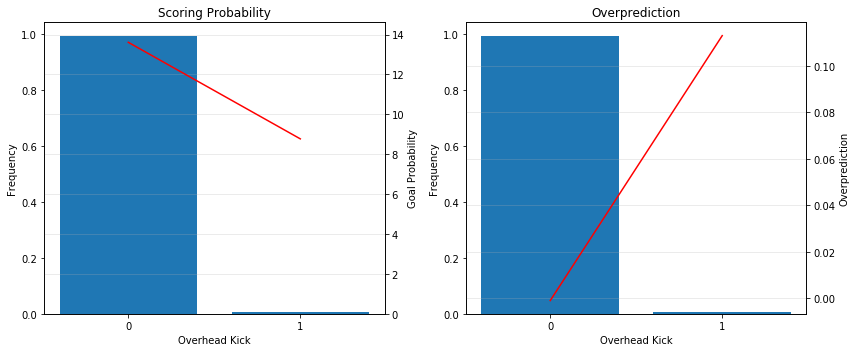

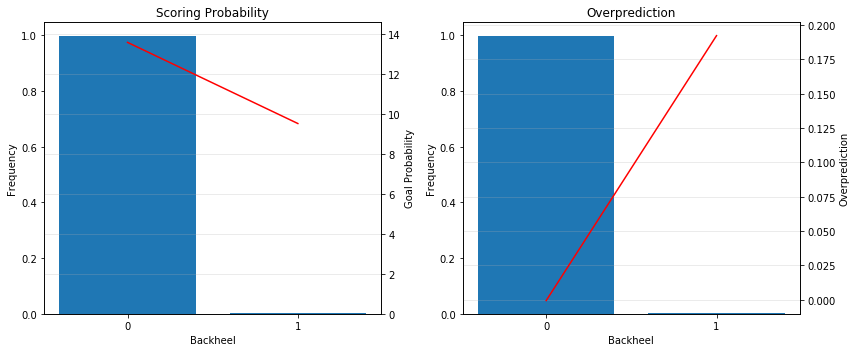

In [96]:
for i in df_train['technique'].unique():
    col = i
    prob_overpred_plot(df_train, col)

- *Volley* : ~0.014 total overprediction for ~6% of shots
- *Half Volley* : ~0.024 total overprediction for ~10% of shots
- *Lob* : ~0.172 total overprediction for ~2% of shots
- *Diving Header* : ~0.052 total overprediction for <1% of shots
- *Overhead Kick* : ~0.114 total overprediction for <1% of shots
- *Backheel* : ~0.193 total overprediction for <1% of shots

### Body part

Without the ability to tell what is a player's strong foot, I will just have to settle for distinguishing shots taken by foot or head. Firstly, it is important to note that the StatsBomb data also has an *Other* type for `body_part`. These make up just 0.24% of all shots so I will include them with *Head*.

In [1414]:
shots['body_part'].value_counts()

Right Foot    5161
Left Foot     3652
Head          1414
Other           25
Name: body_part, dtype: int64

Create a function that returns 0 if a shot was taken by foot and 1 otherwise (mostly head). Then create a new ``head`` feature which describes whether a shot was taken with the head (1) or foot (0).

In [97]:
def transform_body_part(row):
    if row['body_part'] == 'Left Foot':
        return 0
    elif row['body_part'] == 'Right Foot':
        return 0
    elif row['body_part'] is 'Head' or 'Other':
        return 1
    else:
        return None

In [98]:
 df_train['head'] = df_train.apply(transform_body_part, axis=1)
df_test['head'] = df_test.apply(transform_body_part, axis=1)

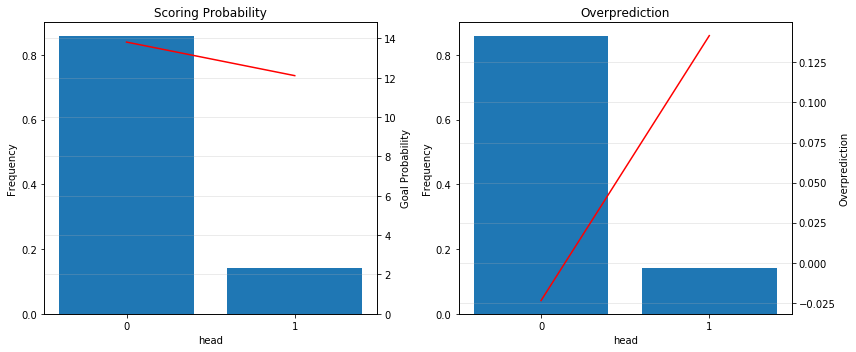

In [99]:
prob_overpred_plot(df_train, 'head')

With a total overprediction ~0.11 and making up ~14% of shots this could have a reasonable impact.

### Creating the new model with the new features

Incorporating all these new features discussed above to create a new model. The error arises because the features haven't been scaled, this will be done later.

In [100]:
features = ['dist','angle','under_pressure','first_time','open_goal','Volley','Half Volley','Lob','Overhead Kick',
           'Backheel','Diving Header','head']
target = ['goal']
reg_feat_2 = skl_lm.LogisticRegression()
reg_feat_2.fit(df_train[features], np.array(df_train[target]).ravel())
pred_probs_2 = reg_feat_2.predict_proba(df_test[features])[:,1]
skm.log_loss(df_test[target],pred_probs_2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.30842506861861646

This improved the log loss from 0.3369 to 0.3084, a reduction of ~8.6%, which is good!

Further ideas:
- Use the `play_pattern` variable which outlines whether the play is *Regular Play*, *From Corner*, *From Free Kick*, *From Counter* and so on.
- Use `freeze_frame`.
- Look at the pass related to the shot and take into account what type of pass the shot assist is.

Again look at the overprediction for all zones on the pitch.

In [103]:
features = ['dist','angle','under_pressure','first_time','open_goal','Volley','Half Volley','Lob','Overhead Kick',
           'Backheel','Diving Header','head']
df_train['prediction'] = reg_feat_2.predict_proba(df_train[features])[:,1]
df_train['overprediction'] = df_train['prediction'] - df_train['goal']

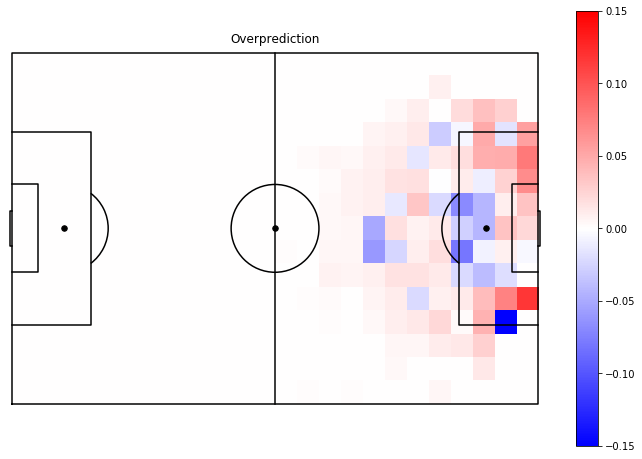

In [110]:
df_overpred = df_train.groupby(['x_zone','y_zone']).agg(overpred_mean=("overprediction","mean")).reset_index()
df_overpred['overpred_mean'].fillna(0,inplace=True)
df_overpred_img = np.array(df_overpred.pivot("y_zone","x_zone","overpred_mean"))

fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(df_overpred_img, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.bwr, vmin=-0.15, vmax=0.15)
fig.colorbar(pos, ax=ax)
ax.set_title("Overprediction")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

There are significant improvements to shots in the zones right in front of the goal.

Only 0.6% of shots (66) have an angle >90. Therefore, I will clip the max angle value to be 100.

In [111]:
df_train['angle_clip'] = df_train['angle'].clip(upper=100)
df_test['angle_clip'] = df_test['angle'].clip(upper=100)

features = ['dist','under_pressure','first_time','open_goal','Volley','Half Volley','Lob','Overhead Kick',
           'Backheel','Diving Header','head','angle_clip']
target = ['goal']
reg_feat_3 = skl_lm.LogisticRegression()
reg_feat_3.fit(df_train[features], np.array(df_train[target]).ravel())
pred_probs_3 = reg_feat_3.predict_proba(df_test[features])[:,1]
skm.log_loss(df_test[target],pred_probs_3)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.308331058794081

This slightly further improves the log loss.

In [112]:
features = ['dist','under_pressure','first_time','open_goal','Volley','Half Volley','Lob','Overhead Kick',
           'Backheel','Diving Header','head','angle_clip']
df_train['prediction'] = reg_feat_3.predict_proba(df_train[features])[:,1]
df_train['overprediction'] = df_train['prediction'] - df_train['goal']

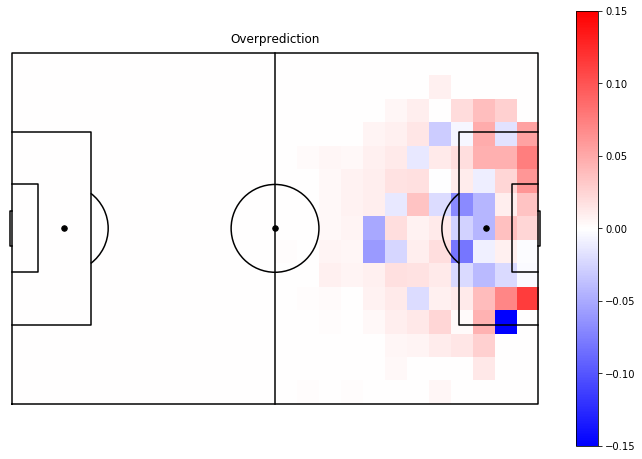

In [113]:
df_overpred = df_train.groupby(['x_zone','y_zone']).agg(overpred_mean=("overprediction","mean")).reset_index()
df_overpred['overpred_mean'].fillna(0,inplace=True)
df_overpred_img = np.array(df_overpred.pivot("y_zone","x_zone","overpred_mean"))

fig,ax = dp.draw_pitch('w','k','h','f')
pos=ax.imshow(df_overpred_img, extent=[0,120,0,80], aspect='auto',cmap=plt.cm.bwr, vmin=-0.15, vmax=0.15)
fig.colorbar(pos, ax=ax)
ax.set_title("Overprediction")
#plt.tight_layout()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

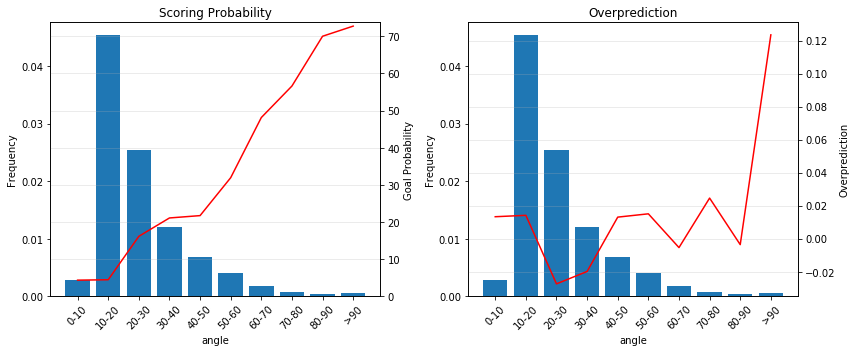

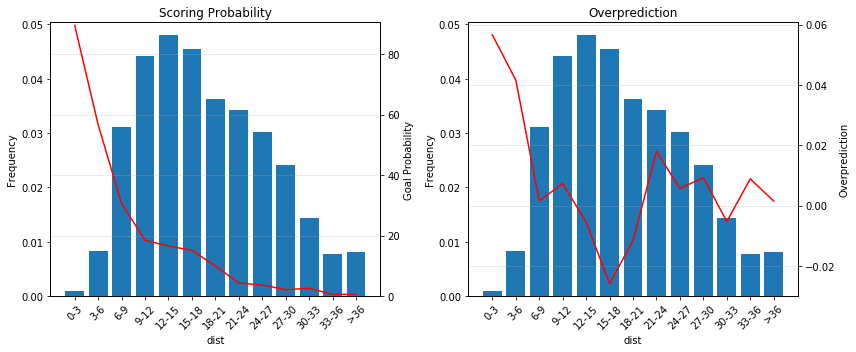

In [116]:
prob_overpred_plot(df_train,'angle',bins = np.arange(0,110,10),cut=True)
prob_overpred_plot(df_train,'dist',bins = np.arange(0,42,3),cut=True)

From these plots it seems that goals from close range (large angles, small distance) have the largest error.

## Interaction terms

Additional features can also be created from interactions between current features. For example, something like ``head``*``distance`` makes sense from a footballing perspective as you would expect the chance to score a header to change differently with distance than shots taken with a foot. Let's study how headers differ from shots taken with a foot.

In [117]:
df_foot = df_train[df_train['head'] == 0]
df_head = df_train[df_train['head'] == 1]

Plotting foot and head shots separately, where foot is top row and head is bottom row.

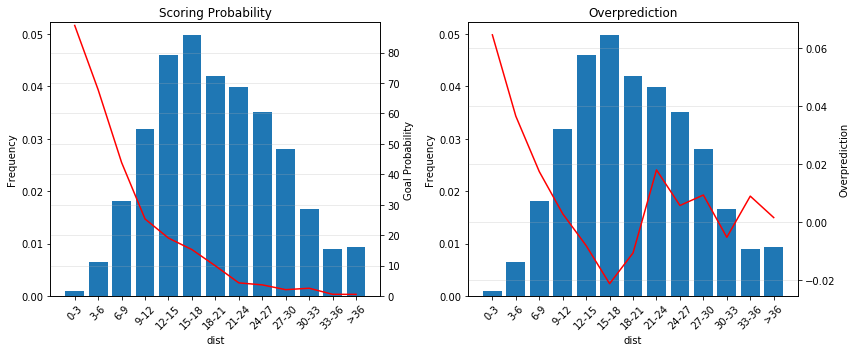

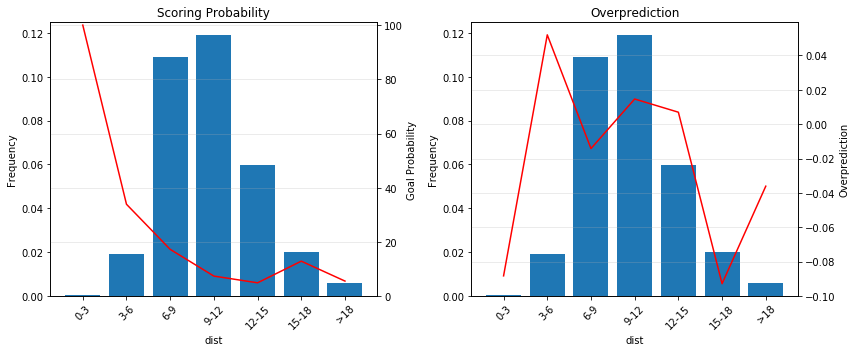

In [118]:
prob_overpred_plot(df_foot,'dist',bins = np.arange(0,42,3),cut=True)
prob_overpred_plot(df_head,'dist',bins = np.arange(0,24,3),cut=True)

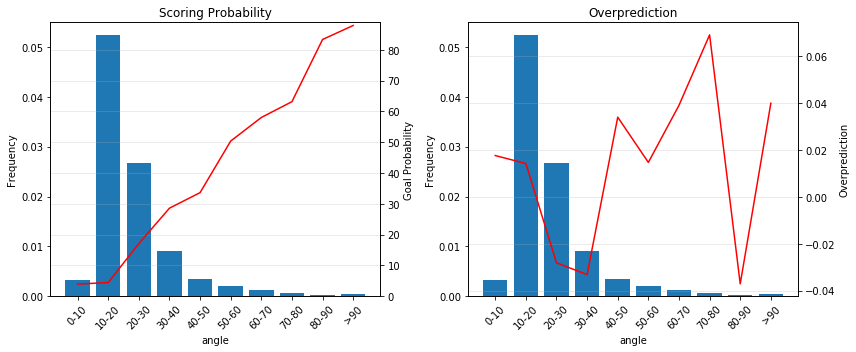

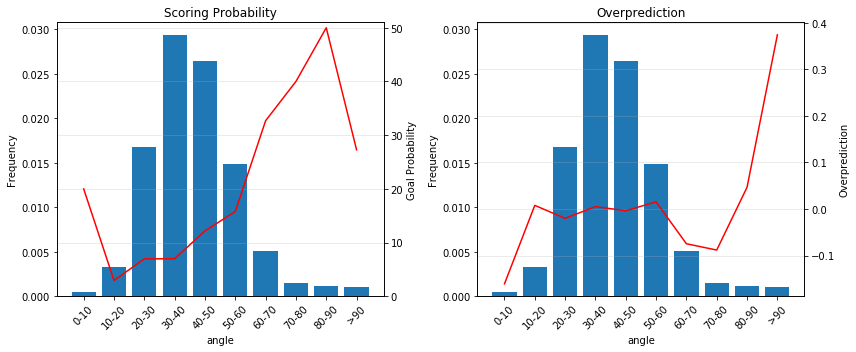

In [119]:
prob_overpred_plot(df_foot,'angle',bins = np.arange(0,110,10),cut=True)
prob_overpred_plot(df_head,'angle',bins = np.arange(0,110,10),cut=True)

We see that scoring probability for headers drops off much quicker with distance than shots with a foot. So far the model does not account for this - it simply says a header is always a certain amount worse than a shot. However, the overprediction is not particularly large.

To try to account for this difference new features can be created, an interaction between headers and distance and angle.

In [120]:
df_train['head_dist'] = df_train['head'] * df_train['dist']
df_test['head_dist'] = df_test['head'] * df_test['dist']
df_train['head_angle'] = df_train['head'] * df_train['angle']
df_test['head_angle'] = df_test['head'] * df_test['angle']

In [121]:
features = ['dist','under_pressure','first_time','open_goal','Volley','Half Volley','Lob','Overhead Kick',
           'Backheel','head','Diving Header','angle_clip','head_dist','head_angle']
target = ['goal']
reg_int = skl_lm.LogisticRegression()
reg_int.fit(df_train[features], np.array(df_train[target]).ravel())
pred_probs_int = reg_int.predict_proba(df_test[features])[:,1]
skm.log_loss(df_test[target],pred_probs_int)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.30830817243088093

In [122]:
df_train['prediction'] = reg_int.predict_proba(df_train[features])[:,1]
df_train['overprediction'] = df_train['prediction'] - df_train['goal']

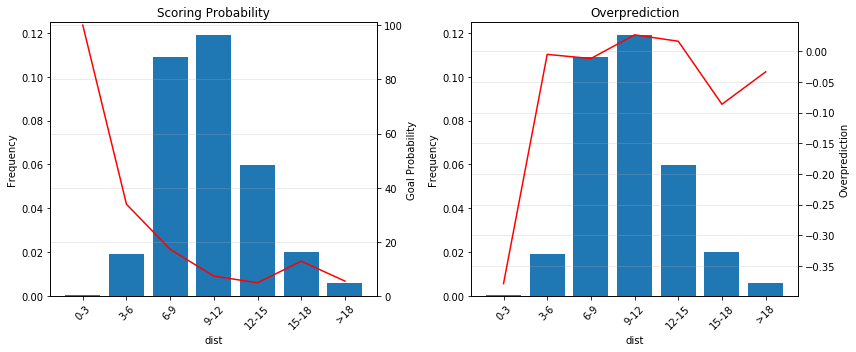

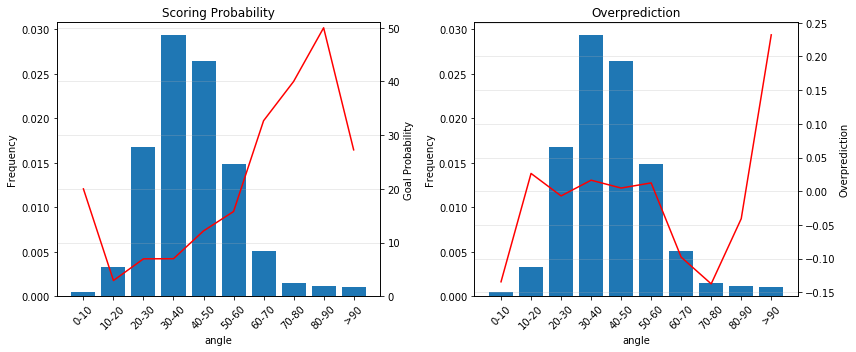

In [123]:
df_head = df_train[df_train['head'] == 1]
prob_overpred_plot(df_head,'dist',bins = np.arange(0,24,3),cut=True)
prob_overpred_plot(df_head,'angle',bins = np.arange(0,110,10),cut=True)

Adding both these new *head_dist* and *head_angle* features improves the log loss but only when they are both included. Additionally, looking at the distance plot we now see headers from very close range a very underpredicted. I'm not sure adding these features has really been an improvement.

To see how if some features are describing the same thing we can look at their correlation.

In [136]:
cm = plt.cm.Reds
df_train[features].corr().abs().style.background_gradient(cmap=cm)

,dist,under_pressure,first_time,open_goal,Volley,Half Volley,Lob,Overhead Kick,Backheel,head,Diving Header,angle_clip,head_dist,head_angle
dist,1.000000,0.117810,0.114785,0.177975,0.066110,0.001612,0.037367,0.064140,0.054186,0.389963,0.068954,0.729971,0.319220,0.404462
under_pressure,0.117810,1.000000,0.158477,0.048972,0.098831,0.039243,0.034826,0.033825,0.012006,0.287188,0.017934,0.092266,0.268252,0.266114
first_time,0.114785,0.158477,1.000000,0.096940,0.318984,0.210032,0.010659,0.084707,0.050129,0.272053,0.049566,0.115989,0.255950,0.252099
open_goal,0.177975,0.048972,0.096940,1.000000,0.003029,0.000122,0.017483,0.010529,0.006375,0.017111,0.025634,0.337176,0.034953,0.025895
Volley,0.066110,0.098831,0.318984,0.003029,1.000000,0.088786,0.039201,0.023608,0.014293,0.102794,0.018734,0.068637,0.097221,0.094581
Half Volley,0.001612,0.039243,0.210032,0.000122,0.088786,1.000000,0.050001,0.030112,0.018231,0.137296,0.023896,0.013930,0.129549,0.127779
Lob,0.037367,0.034826,0.010659,0.017483,0.039201,0.050001,1.000000,0.013295,0.008050,0.049656,0.010550,0.024793,0.041644,0.049220
Overhead Kick,0.064140,0.033825,0.084707,0.010529,0.023608,0.030112,0.013295,1.000000,0.004848,0.036506,0.006354,0.047549,0.034447,0.033976
Backheel,0.054186,0.012006,0.050129,0.006375,0.014293,0.018231,0.008050,0.004848,1.000000,0.022103,0.003847,0.067154,0.020856,0.020571
head,0.389963,0.287188,0.272053,0.017111,0.102794,0.137296,0.049656,0.036506,0.022103,1.000000,0.174045,0.439098,0.943577,0.930681


Looking at the correlations we see, as would be expected, a large correlation between *head*, *head_dist* and *head_angle*. Given the outcomes I just mentioned I will just keep the *head* feature and remove the others.

Further interaction terms can be made to see if they improve the model.

In [137]:
df_train['inv_dist'] = 1/df_train['dist']
df_train['dist_squared'] = df_train['dist'] * df_train['dist']
df_train['dist_angle'] = df_train['dist'] * df_train['angle']
df_train['ft_angle'] = df_train['first_time'] * df_train['angle']
df_train['ft_up'] = df_train['first_time'] * df_train['under_pressure']
df_train['test'] = df_train['head'] * df_train['angle_clip']

In [138]:
df_test['inv_dist'] = 1/df_test['dist']
df_test['dist_squared'] = df_test['dist'] * df_test['dist']
df_test['dist_angle'] = df_test['dist'] * df_test['angle']
df_test['ft_angle'] = df_test['first_time'] * df_test['angle']
df_test['ft_up'] = df_test['first_time'] * df_test['under_pressure']
df_test['test'] = df_test['head'] * df_test['angle_clip']

In [139]:
features = ['dist','angle_clip','under_pressure','first_time','open_goal','Volley','Half Volley','Lob','Overhead Kick',
           'Backheel','Diving Header','head','inv_dist','dist_angle','ft_angle','ft_up']
target = ['goal']
reg_int_2 = skl_lm.LogisticRegression()
reg_int_2.fit(df_train[features], np.array(df_train[target]).ravel())
pred_probs_int_2 = reg_int_2.predict_proba(df_test[features])[:,1]
skm.log_loss(df_test[target],pred_probs_int_2)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.30557420853623196

In [140]:
df_train['prediction'] = reg_int_2.predict_proba(df_train[features])[:,1]
df_train['overprediction'] = df_train['prediction'] - df_train['goal']

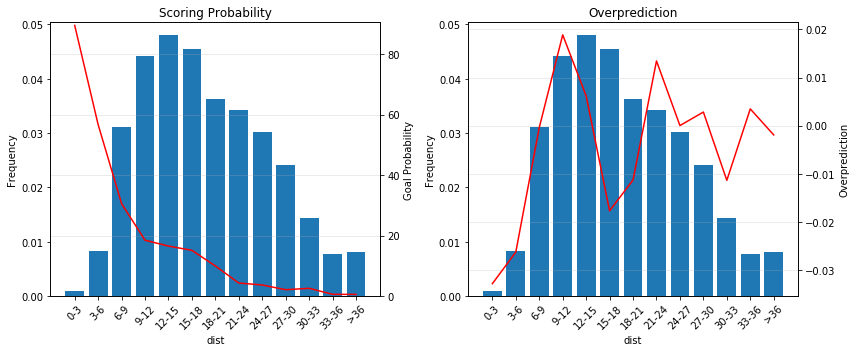

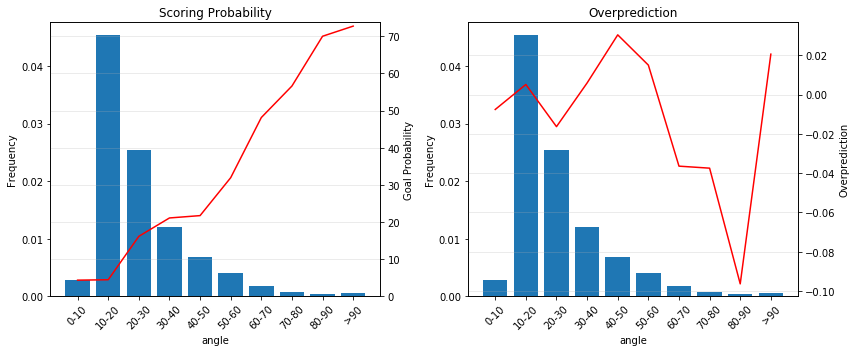

In [141]:
prob_overpred_plot(df_train,'dist',bins = np.arange(0,42,3),cut=True)
prob_overpred_plot(df_train,'angle',bins = np.arange(0,110,10),cut=True)

A look at the correlation of the final features.

In [142]:
df_corr = df_train[features].corr()
correls = np.abs(df_corr.values)
np.fill_diagonal(correls, 0)

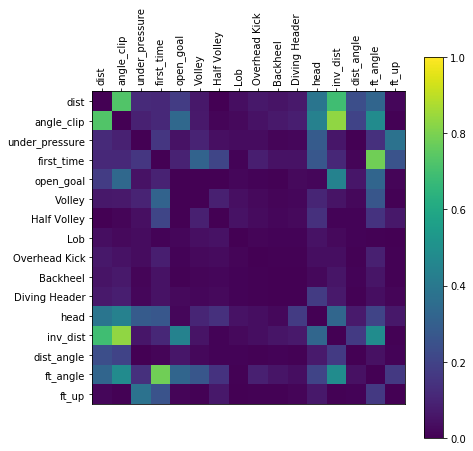

In [143]:
fig,ax = plt.subplots(figsize=(7,7))
pos = ax.imshow(correls,vmin=0,vmax=1)
ax.set_xticks(np.arange(len(features)))
ax.set_xticklabels(features,rotation=90)
ax.xaxis.tick_top()
ax.set_yticks(np.arange(len(features)))
ax.set_yticklabels(features)
fig.colorbar(pos, ax=ax)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Calibration

Calibration means that if the model says that a shot has a goal probability of 0.8, then 80% of shots with this probability are actually a goal. To check this is the case a calibration curve can be plotted. This essentially means splitting the predicted probabilities into bins. Calculate the mean predicted probability of a shot in that bin. Then calculate the actual fraction of shots that were a goal. Plot this fraction of goals against the mean prediction. A well calibrated model means these values are close for each bin.

*sk_learn* actually has a function for doing this under the *calibration* module called *calibration_curve*.

In [144]:
fraction_of_positives, mean_predicted_value = skc.calibration_curve(df_test['goal'].values, pred_probs_int_2, n_bins=10)

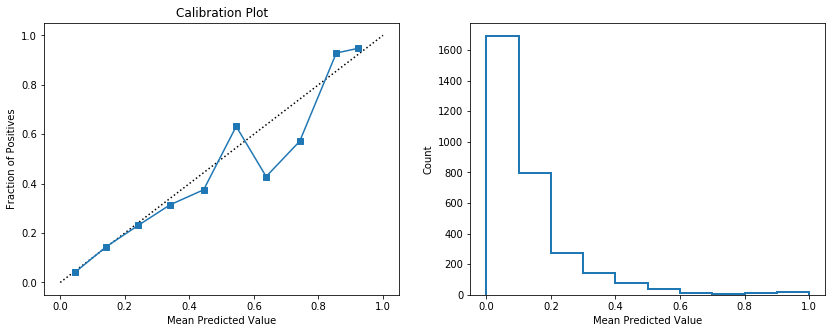

In [145]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(14,5))
ax1.plot([0,1],[0,1], 'k:')
ax1.plot(mean_predicted_value, fraction_of_positives, 's-')
ax1.set_xlabel("Mean Predicted Value")
ax1.set_ylabel("Fraction of Positives")
ax1.set_title("Calibration Plot")

ax2.hist(pred_probs_int_2, range=(0, 1), bins=10, histtype="step", lw=2)
ax2.set_xlabel("Mean Predicted Value")
ax2.set_ylabel("Count")
plt.show()

## Feature Scaling

The value of some of the features lie on quite different scales. For example
- *dist* lies between 0 and around 82
- *angle* lies between 0 and 180
- *under_pressure* etc are binary values, either 0 or 1.

When performing logistic regression (or any machine learning exercise) one should perform feature scaling to bring all variables into similar value ranges. One standard way of doing this is using
$$
\tilde{x} = \frac{x-\bar{x}}{\sigma}\ ,
$$
where $\bar{x}$ is the mean of the feature and $\sigma$ is the standard deviation of that feature.

In [146]:
features = ['dist','angle_clip','under_pressure','first_time','open_goal','Volley','Half Volley','Lob',
            'Overhead Kick','Backheel','Diving Header','head','inv_dist','dist_angle','ft_angle','ft_up']
target = ['goal']

feat_train = df_train[features].copy()
feat_test = df_test[features].copy()

for feat in features:
    mean_feat = feat_train[feat].mean()
    std_feat = feat_train[feat].std()
    
    feat_train[feat] = (feat_train[feat] - mean_feat) / std_feat
    feat_test[feat] = (feat_test[feat] - mean_feat) / std_feat
    
reg_final = skl_lm.LogisticRegression()
reg_final.fit(feat_train[features], np.array(df_train[target]).ravel())
pred_probs_final = reg_final.predict_proba(feat_test[features])[:,1]
print("Log loss:",skm.log_loss(df_test[target],pred_probs_final))
print("AUC score:", skm.roc_auc_score(df_test[target], pred_probs_final)*100)

Log loss: 0.3056341132538341
AUC score: 79.844459529946
